In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import jax.numpy as jnp
import dynamiqs as dq
from matplotlib.colors import Normalize, TwoSlopeNorm
import imageio
import os

results_path = "C:/Users/solom/Desktop/AliceBob25/task1_a/"


### Fock states

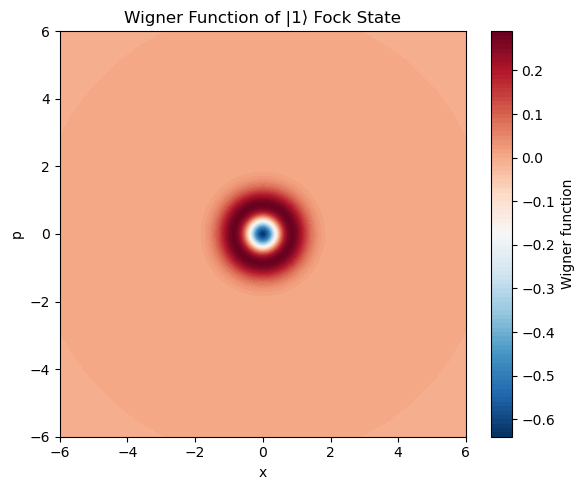

In [2]:
# Parameters
n = 1  # Fock state number
N = 20  # Hilbert space dimension

# Create Fock state
psi = dq.fock(N, n)

# Compute Wigner function
xvec, yvec, W = dq.wigner(psi)

# Plot it
plt.figure(figsize=(6, 5))
plt.contourf(xvec, yvec, W, levels=100, cmap='RdBu_r')
plt.colorbar(label="Wigner function")
plt.xlabel("x")
plt.ylabel("p")
plt.title(f"Wigner Function of |{n}⟩ Fock State")
plt.tight_layout()
# Save the plot
plt.savefig(results_path + f"wigner_fock_{n}.png", dpi=300)

### Coherent states

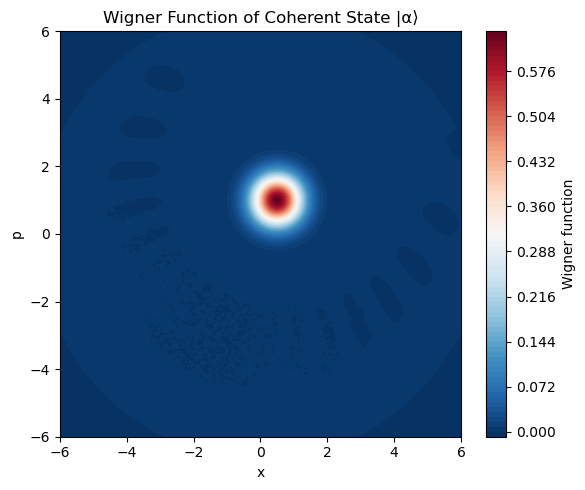

In [3]:
# Create coherent state with alpha = 1 + 0.5i in a Hilbert space of dimension 20
alpha = 1 + 0.5j 
psi = dq.coherent(dim=20, alpha=alpha)

# Compute Wigner function
xvec, yvec, W = dq.wigner(psi)

# Plot
plt.figure(figsize=(6, 5))
plt.contourf(xvec, yvec, W, levels=100, cmap='RdBu_r')
plt.colorbar(label="Wigner function")
plt.xlabel("x")
plt.ylabel("p")
plt.title("Wigner Function of Coherent State |α⟩")
plt.tight_layout()
# Save the plot
plt.savefig(results_path + f"wigner_coherent_{alpha}.png", dpi=300)


### Cat states

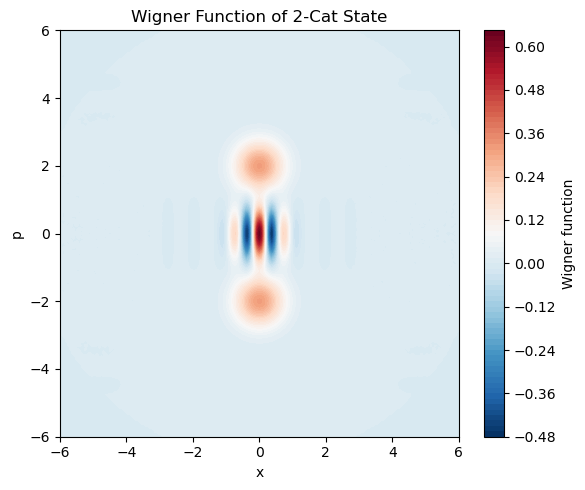

In [ ]:
# 2-cat state
# Parameters
alpha = 2.0
dim = 40

# Build two coherent states
psi1 = dq.coherent(dim=dim, alpha=alpha)
psi2 = dq.coherent(dim=dim, alpha=-alpha)

# Superpose and normalize
psi_cat = np.sqrt(2)**(-1) * (psi1 + psi2)

# Compute Wigner function
xvec, yvec, W = dq.wigner(psi_cat)

# Plot
plt.figure(figsize=(6, 5))
plt.contourf(xvec, yvec, W, levels=100, cmap='RdBu_r')
plt.colorbar(label="Wigner function")
plt.xlabel("x")
plt.ylabel("p")
plt.title("Wigner Function of 2-Cat State")
plt.tight_layout()
# Save the plot
plt.savefig(results_path + f"wigner_2cat.png", bbox_inches = 'tight', dpi=300)

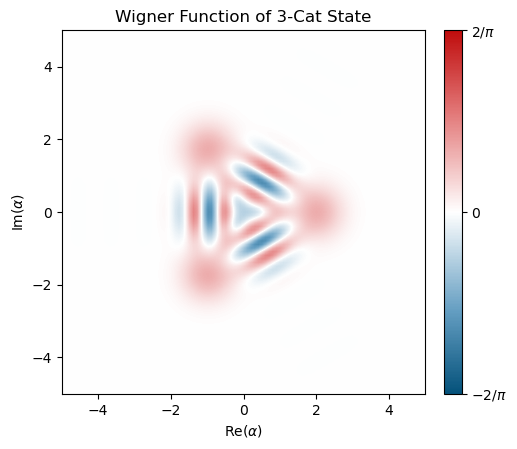

In [6]:
# 3-cat state
# Parameters
alpha = 2.0
dim = 50  # Hilbert space dimension

# Define phases for the three coherent states
phases = np.exp(2j * np.pi * np.arange(3) / 3)

# Create and sum the coherent states
psi_cat3 = sum(dq.coherent(dim, alpha * phase) for phase in phases)

# Normalize the superposition
psi_cat3 = dq.unit(psi_cat3)

# Plot Wigner function
dq.plot.wigner(psi_cat3)
plt.title("Wigner Function of 3-Cat State")
# Save the plot
plt.savefig(results_path + f"wigner_3cat.png", bbox_inches = 'tight', dpi=300)

### Dissipative Cat State from a Two-Photon Exchange Hamiltonian

|██████████| 100.0% ◆ elapsed 1.15s ◆ remaining 0.00ms     


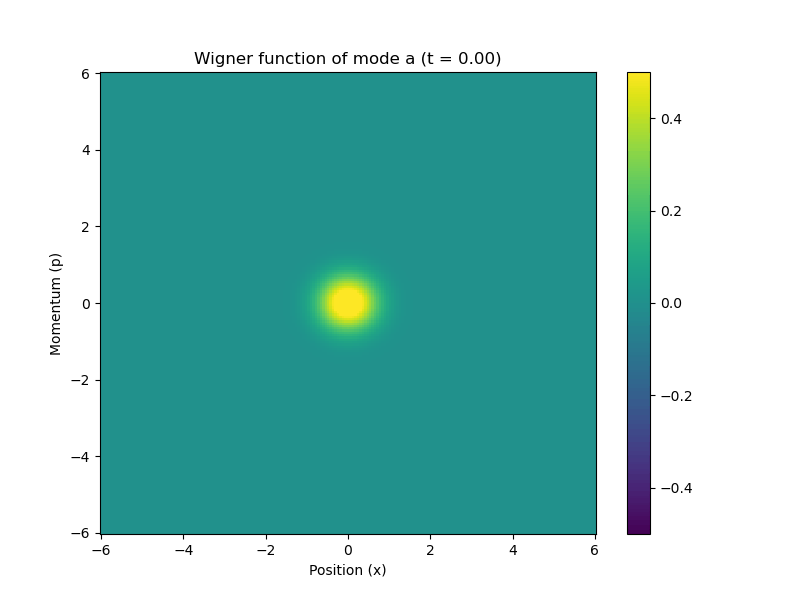

In [ ]:
import dynamiqs as dq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

# Parameters
g2 = 1.0          # Two-photon coupling strength
epsilon_b = -4    # Drive amplitude
kappa_b = 10      # Dissipation rate
T = 4             # Final time
nt = 100          # Number of time points to save
N_a = 20          # Hilbert space dimension for mode a
N_b = 10          # Hilbert space dimension for mode b

# Time points for saving results
tsave = np.linspace(0, T, nt)

# Operators
a = dq.destroy(N_a)
b = dq.destroy(N_b)
I_a = dq.eye(N_a)  # Identity for mode a
I_b = dq.eye(N_b)  # Identity for mode b

# Hermitian conjugates
a_dag = dq.dag(a)  # a†
b_dag = dq.dag(b)  # b†

# Hamiltonian terms using proper tensor products
H_term1 = g2 * dq.tensor(a_dag @ a_dag, b)      # g₂*a†² ⊗ b
H_term2 = g2 * dq.tensor(a @ a, b_dag)          # g₂*a² ⊗ b†
H_term3 = np.conj(epsilon_b) * dq.tensor(I_a, b)  # ε_b* I ⊗ b
H_term4 = epsilon_b * dq.tensor(I_a, b_dag)       # ε_b I ⊗ b†

# Full Hamiltonian
H = H_term1 + H_term2 + H_term3 + H_term4

# Jump operators (only b mode dissipation)
jump_ops = [np.sqrt(kappa_b) * dq.tensor(I_a, b)]

# Initial state (both modes in vacuum)
rho0 = dq.tensor(dq.fock_dm(N_a, 0), dq.fock_dm(N_b, 0))

# Time evolution
result = dq.mesolve(
    H=H,
    jump_ops=jump_ops,
    rho0=rho0,
    tsave=tsave,
    options=dq.Options(save_states=True)
)

# Prepare Wigner function data for animation
xvec = np.linspace(-5, 5, 100)
yvec = np.linspace(-5, 5, 100)
wigner_data = []

# Fixed partial trace implementation
def partial_trace(state, dims, keep):
    """Manual partial trace implementation"""
    dims = np.asarray(dims)
    keep = np.asarray(keep)
    dims_kept = dims[keep]
    dims_trace = np.delete(dims, keep)
    
    # Reshape the state to [d1, d2, d1, d2]
    rho = np.reshape(state, [dims[0], dims[1], dims[0], dims[1]])
    
    # Trace out the second subsystem (axis1=1, axis2=3)
    traced_out = np.trace(rho, axis1=1, axis2=3)
    
    # The result is already in correct shape [d1, d1]
    return traced_out

for state in result.states:
    # Perform partial trace manually
    rho_a = partial_trace(np.array(state), [N_a, N_b], 0)
    # Compute Wigner function
    xvec, yvec, W = dq.wigner(rho_a)
    wigner_data.append(W)

# Create animation
fig, ax = plt.subplots(figsize=(8, 6))
X, Y = np.meshgrid(xvec, yvec)
wigner_plot = ax.pcolormesh(X, Y, wigner_data[0], shading='auto', vmin=-0.5, vmax=0.5)
plt.colorbar(wigner_plot, ax=ax)
ax.set_title('Wigner function of mode a')
ax.set_xlabel('Position (x)')
ax.set_ylabel('Momentum (p)')

def update(frame):
    wigner_plot.set_array(wigner_data[frame].ravel())
    ax.set_title(f'Wigner function of mode a (t = {result.tsave[frame]:.2f})')
    return wigner_plot,

ani = FuncAnimation(fig, update, frames=len(result.states), interval=50)

# Save as GIF
results_path = "C:/Users/solom/Desktop/AliceBob25/"
ani.save(results_path + 'wigner_evolution.gif', writer='pillow', fps=15, dpi=100)
plt.close()

# Display the GIF (in Jupyter notebook)
Image.open('wigner_evolution.gif')